In [0]:
#@title Libraries
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from types import SimpleNamespace
from __future__ import print_function

In [0]:
#@title Configuration
plt.ion()
hparams = SimpleNamespace(
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
  imsize = 512 if torch.cuda.is_available() else 128,  # use small size if no gpu
  # desired depth layers to compute style/content losses
  content_layers_default = ['conv_4'],
  style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
)
hparams

namespace(content_layers_default=['conv_4'], device=device(type='cuda'), imsize=512, style_layers_default=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])

In [0]:
#@title Image Loaders/Utils

loader = transforms.Compose([
  transforms.Resize((hparams.imsize, hparams.imsize)),  # scale imported image
  transforms.ToTensor() # transform it into a torch tensor
])  
unloader = transforms.ToPILImage()  # reconvert into PIL image

def image_loader(image_name: str = ''):
  image = Image.open(image_name)
  # fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)
  return image.to(hparams.device, torch.float)

def imshow(tensor, title=None):
  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

In [0]:
#@title Content & Style Images
content_image_url = 'https://million-wallpapers.com/wallpapers/4/15/362473219318814/anne-hathaway-portrait.jpg' #@param {type:"string"}
content_image = 'content.jpg'
!wget -O "$content_image" "$content_image_url"
style_image_url = 'https://uploads3.wikiart.org/00142/images/vincent-van-gogh/the-starry-night.jpg' #@param {type:"string"}
style_image = 'style.jpg'
!wget -O "$style_image" "$style_image_url"

hparams.style_img = image_loader(style_image)
hparams.content_img = image_loader(content_image)

hparams.style_img.size(), hparams.content_img.size()

--2020-04-20 00:39:41--  https://million-wallpapers.com/wallpapers/4/15/362473219318814/anne-hathaway-portrait.jpg
Resolving million-wallpapers.com (million-wallpapers.com)... 31.131.20.154
Connecting to million-wallpapers.com (million-wallpapers.com)|31.131.20.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221904 (217K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>] 216.70K   273KB/s    in 0.8s    

2020-04-20 00:39:43 (273 KB/s) - ‘content.jpg’ saved [221904/221904]

--2020-04-20 00:39:45--  https://uploads3.wikiart.org/00142/images/vincent-van-gogh/the-starry-night.jpg
Resolving uploads3.wikiart.org (uploads3.wikiart.org)... 95.211.148.46
Connecting to uploads3.wikiart.org (uploads3.wikiart.org)|95.211.148.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9150166 (8.7M) [image/jpg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>]   8.73M  2.85MB/s    in 3.1s    

20

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

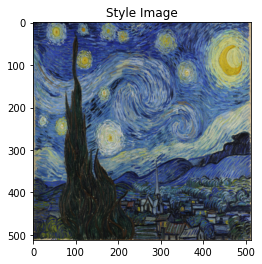

In [0]:
#@title Showing Style Image
plt.figure()
imshow(hparams.style_img, title='Style Image')

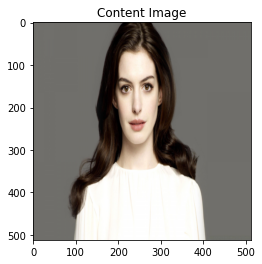

In [0]:
#@title Showing Content Image
plt.figure()
imshow(hparams.content_img, title='Content Image')

In [0]:
#@title Content Loss: `ContentLoss(nn.Module)`
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [0]:
#@title Style Loss: `StyleLoss(nn.Module)`

def gram_matrix(input):
  r"""
  A gram matrix is the result of multiplying a given matrix by its transposed matrix.
  """
  a, b, c, d = input.size()  # a=batch size(=1)
  # b=number of feature maps
  # (c,d)=dimensions of a f. map (N=c*d)

  features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

  G = torch.mm(features, features.t())  # compute the gram product

  # we 'normalize' the values of the gram matrix
  # by dividing by the number of element in each feature maps.
  return G.div(a * b * c * d)

class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

In [0]:
#@title CNN pre-trained features model
cnn = models.vgg19(pretrained=True).features.to(hparams.device).eval()
cnn 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
#@title Model Normalization

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(hparams.device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(hparams.device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # .view the mean and std to make them [C x 1 x 1] so that they can
    # directly work with image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # normalize img
    return (img - self.mean) / self.std

In [0]:
#@title Custom ContentStyleModel

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=hparams.content_layers_default,
                               style_layers=hparams.style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(hparams.device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

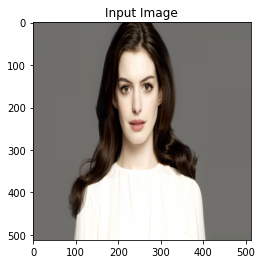

In [0]:
#@title Input image for the model
input_img = hparams.content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [0]:
#@title Optimizer

def get_input_optimizer(input_img):
  # this line to show that input is a parameter that requires a gradient
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [0]:
#@title Training Style Transfer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [0]:
#@title Output image from training
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            hparams.content_img, hparams.style_img, input_img)

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 117.936157 Content Loss: 24.828661

run [100]:
Style Loss : 36.929539 Content Loss: 23.986704

run [150]:
Style Loss : 11.771343 Content Loss: 22.727062

run [200]:
Style Loss : 5.918418 Content Loss: 21.302443

run [250]:
Style Loss : 3.860839 Content Loss: 19.815361

run [300]:
Style Loss : 3.020558 Content Loss: 18.727543



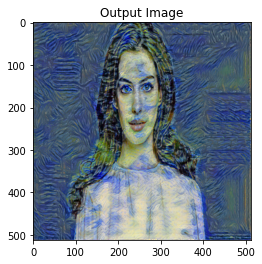

In [0]:
#@title Showing output stylished image
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()